In [1]:
import torch
import math
import torchvision
import torchvision.transforms as transforms
from preresnet import PreResNet
import torch.nn.functional as F
import matplotlib.pyplot as plt
import tqdm.notebook as tq

In [2]:
def load_data_cifar10():
    transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    train_set = torchvision.datasets.CIFAR10(
        root='.data', train=True, download=True, transform=transform)

    test_set = torchvision.datasets.CIFAR10(
        root='.data', train=False, download=True, transform=transform)
    return train_set, test_set


def load_data_mnist():
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    train_set = torchvision.datasets.MNIST(
        root='.data', train=True, download=True, transform=transform)

    test_set = torchvision.datasets.MNIST(
        root='.data', train=False, download=True, transform=transform)
    return train_set, test_set


train_set, test_set = load_data_mnist()
n_data = train_set.data.shape[0]

In [30]:
model = torch.nn.Sequential(torch.nn.Flatten(), torch.nn.Linear(
    28 * 28, 512), torch.nn.Linear(512, 512), torch.nn.ReLU(), torch.nn.Linear(512, 512), torch.nn.ReLU(), torch.nn.Linear(512, 10))


def squared_norm(values):
    result = 0
    for value in values:
        result += torch.norm(value) ** 2
    return result


def forward(batch, model):
    images, labels = batch
    logits = model(images)
    _, predictions = logits.max(1)
    correct = (predictions == labels).sum()
    loss = F.cross_entropy(logits, labels, reduction='mean')
    return loss, correct


def validation(test_loader, model):
    n = 0
    correct_count = 0.0
    total_loss = 0.0
    test_iter = iter(test_loader)
    with torch.no_grad():
        for images, labels in test_iter:
            batch = (images, labels)
            batch_size = batch[0].shape[0]
            n += batch_size
            average_loss, correct = forward(batch, model)
            total_loss += average_loss * batch_size
            correct_count += correct
    return total_loss.item() / n, correct_count.item() / n


def update_aggregates(model, aggregated_gradients, aggregated_gradient_squares):
    with torch.no_grad():
        for i, parameter in enumerate(model.parameters()):
            aggregated_gradients[i] += parameter.grad / n_data
            aggregated_gradient_squares[i] += torch.norm(
                parameter.grad)**2 / n_data


def get_layer_wise_norms(model):
    w = []
    g = []
    for p in model.parameters():
        if p.requires_grad:
            w.append(p.view(-1).norm().item())
            g.append(p.grad.view(-1).norm().item())
    return w, g

def calculate_statistics(model, dataloader):
    # TODO: Adjust for batch size
    dataiter = iter(dataloader)
    aggregated_gradients = [torch.zeros_like(
        parameter) for parameter in model.parameters()]
    aggregated_gradient_squares = [0 for parameter in model.parameters()]
    for i, batch in enumerate(dataiter):
        loss, _ = forward(batch, model)
        loss.backward()
        update_aggregates(model,
                          aggregated_gradients,
                          aggregated_gradient_squares)
    parameter_norm = squared_norm(model.parameters()).item()
    gradient_norm = squared_norm(aggregated_gradients).item()
    gradient_covariance_trace = (sum(
        aggregated_gradient_squares) - gradient_norm).item()
    return parameter_norm, gradient_norm, gradient_covariance_trace


def calculate_norms(model, dataloader):
    # TODO: Adjust for batch size
    dataiter = iter(dataloader)
    weight_grad_history = []
    for i, batch in enumerate(dataiter):
        loss, _ = forward(batch, model)
        loss.backward()
        w, g = get_layer_wise_norms(model)
        weight_grad_history.append({'weight': w, 'gradient': g})

    return weight_grad_history

# TODO: 
# - [x] learning rate scheduler
# - [x] record statistics to create histogram
# - [ ] refactor code
#   - [ ] parameter dictionary
#   - [ ] statistics dictionary
#   - [ ] extract models in separate file
# - [ ] set seed
# - [ ] adjust statistics with batchsize
# - [ ] adjust number of iterations with noise scaling factor
# - [ ] save weights after training
# - [ ] add alexnet
batch_size = 128 * 2
noise_scaling = 1
trainloader = torch.utils.data.DataLoader(
    train_set, batch_size=2 * batch_size, shuffle=True, num_workers=0)
testloader = torch.utils.data.DataLoader(
    test_set, batch_size=2 * batch_size, shuffle=True, num_workers=0)
losses = []
accuracies = []
validation_losses = []
validation_accuracies = []
learning_rate = 0.12 * 2
weight_decay = 0.0005
epochs = 10
learning_rates = 10 ** torch.linspace(-4, 0, 1000)
c1 = (1 + math.sqrt(2 * noise_scaling - 1)) / 2
c2 = (1 - math.sqrt(2 * noise_scaling - 1)) / 2
optimizer = torch.optim.SGD(
    model.parameters(), lr=learning_rate/noise_scaling, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# parameter_norm, gradient_norm, gradient_covariance_trace = calculate_statistics(
#     model, trainloader)
# print(
#     f'norm: {parameter_norm:.3f}, g norm: {gradient_norm}, g trace: {gradient_covariance_trace}')
history = calculate_norms(model, trainloader)
for epoch in tq.tqdm(range(epochs)):
    validation_loss, validation_accuracy = validation(testloader, model)
    print(
        f'Episode: {epoch}, loss: {validation_loss}, accuracy: {validation_accuracy}')
    validation_accuracies.append(validation_accuracy)
    validation_losses.append(validation_loss)
    train_iter = iter(trainloader)
    correct = 0
    for i, (images, labels) in enumerate(train_iter):
        n = images.shape[0] // 2
        batch1 = (images[:n], labels[:n])
        batch2 = (images[n:], labels[n:])
        optimizer.zero_grad()

        loss1, correct1 = forward(
            batch1, model)
        loss2, correct2 = forward(batch2, model)
        loss = c1 * loss1 + c2 * loss2

        losses.append(loss.item())
        correct += correct1 + correct2
        loss.backward()
        optimizer.step()
        if i % 30 == 0 or i == len(train_iter)-1:
            print(f'{i} / {len(train_iter)-1}, loss: {losses[-1]:.3f}')
    scheduler.step()
    # parameter_norm, gradient_norm, gradient_covariance_trace = calculate_statistics(
    #     model, trainloader)
    # print(
    #     f'norm: {parameter_norm:.3f}, g norm: {gradient_norm}, g trace: {gradient_covariance_trace}')


KeyboardInterrupt: 

In [31]:
history = calculate_norms(model, trainloader)


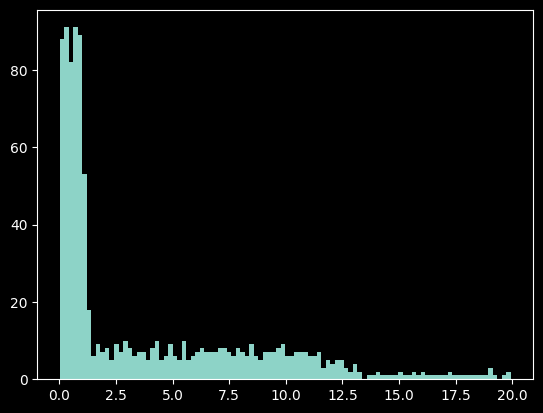

In [29]:
gradient_norms = [gradient for iterate in history for gradient in iterate['gradient']]
plt.hist(gradient_norms, bins=100);
# gradient_norms

In [29]:
model = torch.nn.Sequential(torch.nn.Flatten(), torch.nn.Linear(
    28 * 28, 512), torch.nn.Linear(512, 512), torch.nn.ReLU(), torch.nn.Linear(512, 512), torch.nn.ReLU(), torch.nn.Linear(512, 10))


def forward(batch, model):
    images, labels = batch
    logits = model(images)
    _, predictions = logits.max(1)
    correct = (predictions == labels).sum()
    loss = F.cross_entropy(logits, labels, reduction='mean')
    return loss, correct


def validation(test_loader, model):
    n = 0
    correct_count = 0.0
    total_loss = 0.0
    test_iter = iter(test_loader)
    with torch.no_grad():
        for images, labels in test_iter:
            batch = (images, labels)
            batch_size = batch[0].shape[0]
            n += batch_size
            average_loss, correct = forward(batch, model)
            total_loss += average_loss * batch_size
            correct_count += correct
    return total_loss.item() / n, correct_count.item() / n


batch_size = 128
noise_scaling = 1
trainloader = torch.utils.data.DataLoader(
    train_set, batch_size=60000, shuffle=True, num_workers=0)
losses = []
accuracies = []
validation_losses = []
validation_accuracies = []
learning_rate = 0.12
weight_decay = 0.0005
epochs = 10
learning_rates = 10 ** torch.linspace(-4, 0, 1000)
c1 = (1 + math.sqrt(2 * noise_scaling - 1)) / 2
c2 = (1 - math.sqrt(2 * noise_scaling - 1)) / 2
optimizer = torch.optim.SGD(
    model.parameters(), lr=learning_rate/noise_scaling, weight_decay=weight_decay)
images, labels = next(iter(trainloader))
for i in range(1000):
    for g in optimizer.param_groups:
        g['lr'] = learning_rates[i] / noise_scaling
    ix = torch.randint(0, images.shape[0], (2 * batch_size,))
    batch1 = (images[ix[:batch_size]], labels[ix[:batch_size]])
    batch2 = (images[ix[batch_size:]], labels[ix[batch_size:]])
    optimizer.zero_grad()

    loss1, correct1 = forward(
        batch1, model)
    loss2, correct2 = forward(batch2, model)
    loss = c1 * loss1 + c2 * loss2

    losses.append(loss.item())
    correct += correct1 + correct2
    for p in model.parameters():
        p.grad = None
    loss.backward()
    optimizer.step()
    print(f'{i} / {len(train_iter)-1}, loss: {losses[-1]:.3f}')
print(f'Train accuracy: {correct.item() / len(train_set)}')


KeyboardInterrupt: 

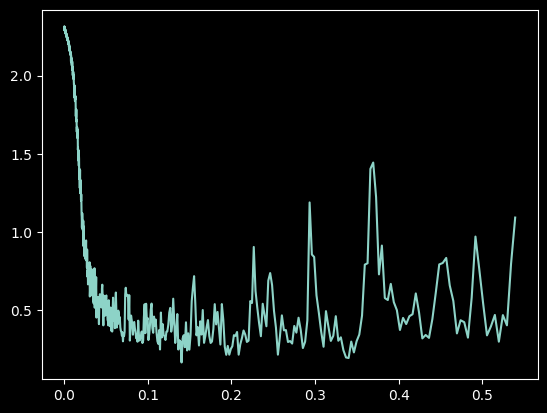

In [28]:

filtered_losses = [(learning_rate, value) for learning_rate, value in zip(
    learning_rates.tolist(), losses) if not math.isnan(value) and value < 2.5]
lr = [learning_rate for learning_rate, _ in filtered_losses]
l = [loss for _, loss in filtered_losses]
plt.plot(lr, l)


In [19]:
dataiter = iter(trainloader)
next(dataiter)

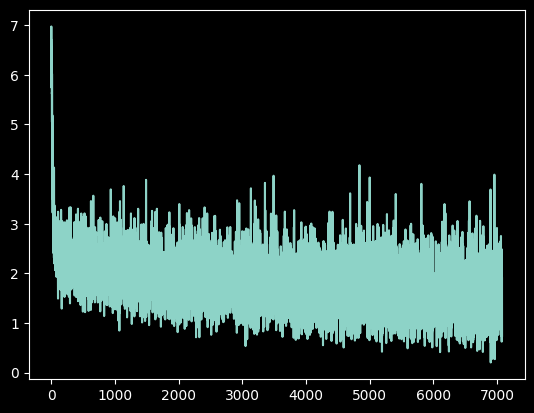

In [19]:
plt.plot(losses)

In [20]:
dataiter = iter(testloader)

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (labels == predicted).sum().item()
correct / total

0.5078